## 1. Importing

In [2]:
from laboneq.simple import *
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
    exponential_decay,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)
from pathlib import Path
import time
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'laboneq.analysis'

## 2. instrument connection and setup

In [3]:
descriptor_shfqc = """
instruments:
  SHFQC:
  - address: DEV12134
    uid: device_shfqc
    interface: 1gbe

connections:
  device_shfqc:
    - iq_signal: q1/drive_line
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: q1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q1/acquire_line
      ports: [QACHANNELS/0/INPUT]

    - iq_signal: q2/drive_line
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: q2/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q2/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""
# Define and Load device setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor_shfqc,
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)
# define shortcut to logical signals for convenience, extract from device setup
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
        for qubit_name in device_setup.logical_signal_groups.keys() # == dict_keys(['q0', 'q1'])
}

In [4]:
session = Session(device_setup=device_setup)
session.connect(do_emulation=True)

2025.01.20 16:55:50.812 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is c:\Users\QEL\Desktop\py\SHFQC\laboneq_output\log
2025.01.20 16:55:50.812 laboneq.controller.controller  INFO   VERSION: laboneq 2.2.0
2025.01.20 16:55:50.813 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2025.01.20 16:55:50.813 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.02 at localhost:8004
2025.01.20 16:55:50.815 laboneq.controller.devices.device_collection INFO   Configuring clock sources
2025.01.20 16:55:50.815 laboneq.controller.devices.device_collection INFO   Clock sources configured


## 3. expriment setup

In [5]:
# define the qubit parameter (rougthly setting)
q1 = Qubit.from_logical_signal_group(
    uid='q1', # the uid of the qubit should match the name in `descriptor_shfqc`.
    lsg=device_setup.logical_signal_groups["q1"],
    parameters=QubitParameters(
        resonance_frequency = 3e+9, # Resonance frequency of the qubit.
        drive_lo_frequency = 3e+9, # LO for the qubit drive line.        
        drive_range = 10, # power range setting for drive line, in dBm, defaults is 10dBm.
        readout_resonator_frequency = 4e+9, # Resonance frequency of the readout resonator. (WE DONT HAVE IT)
        readout_lo_frequency = 4e+9, # LO frequency for the readout lines. (WE DONT HAVE IT)
        readout_range_out = 10, # power range setting for readout line, in dBm, defaults is 10dBm.(WE DONT HAVE IT)
    )
)
# make a map to acess signal channel in a sanytax efficient way
signal_map = {
    "measure": device_setup.logical_signal_groups[q1.uid].logical_signals["measure_line"],
    "acquire": device_setup.logical_signal_groups[q1.uid].logical_signals["acquire_line"],
    "drive": device_setup.logical_signal_groups[q1.uid].logical_signals["drive_line"],
}


NameError: name 'Qubit' is not defined

In [5]:
# q1.calibration() returns a dict for calibration objects that auto created, yet not set
signal_map['drive'].calibration = q1.calibration()[signal_map['drive']] # now set it to signal
signal_map['acquire'].calibration = q1.calibration()[signal_map['acquire']]
signal_map['acquire'].calibration = q1.calibration()[signal_map['acquire']]
# or device_setup.set_calibration(q1.calibration()) would do the previous three lines
signal_map['acquire'].calibration.local_oscillator.frequency = 4.1e+9
signal_map['acquire'].calibration

NameError: name 'q1' is not defined

In [6]:
# a function to define an experiment sequencence
def get_expe(freq_sweep, exp_settings):
    # Create experiment object, specify used channels (we can use our map)
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
            ExperimentSignal("drive"),
        ],
    )

    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec.acquire_loop_rt( # acquire data for many times
        uid="shots",
        count=exp_settings["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY, # way to read data
    ):
        with exp_spec.sweep(uid="res_freq", parameter=freq_sweep): # sweep for each freq
            # readout pulse and data acquisition
            with exp_spec.section(uid="spectroscopy"):
                # resonator signal readout
                exp_spec.acquire(
                    signal="acquire", # signal == channel on instrument
                    handle="expe_result", # handel == the place to store read data
                    length=exp_settings["integration_time"],
                )
            with exp_spec.section(uid="delay", length=10e-6):
                # holdoff time after signal acquisition
                exp_spec.reserve(signal="measure")

    return exp_spec

In [7]:
#### calibration on experiment ####
#---- Note: it returns an calibration object that stores key of channels and correspond values
#----       it will then be set by Experiment.set_calibration().
def get_expe_calib_obj(frequency_sweep, read_lo_freq, amplitude_sweep=None):
    exp_calibration = Calibration()

    exp_calibration["measure"] = SignalCalibration( # we can use our map
        oscillator=Oscillator(
            "readout_osc",
            frequency=frequency_sweep,
            modulation_type=ModulationType.HARDWARE,
        ),
        local_oscillator=Oscillator(
            frequency=read_lo_freq,
        ),
        amplitude=amplitude_sweep,
    )
    exp_calibration["acquire"] = SignalCalibration(
        local_oscillator=Oscillator(
            frequency=read_lo_freq,
        ),
    )
    return exp_calibration

In [8]:
freq_sweep = LinearSweepParameter(
    uid="res_freq",
    start=200.0e6, # start_freq
    stop=300.0e6, # stop_freq
    count=1001, # num_points
)
acquire_settings = {"integration_time": 100e-6, "num_averages": 1}
read_lo_freq = 5e+9
expe = get_expe(freq_sweep, acquire_settings)
expe.set_signal_map(signal_map)
#---- Note: we only `set` the calibration, the calibrating is done when compliling the experiment
expe.set_calibration(get_expe_calib_obj(freq_sweep, read_lo_freq)) 

NameError: name 'signal_map' is not defined

## 4. complile, run and get data

In [21]:
compiled_expe = session.compile(expe)

[2024.08.16 11:09:08.964] INFO    Starting LabOne Q Compiler run...
[2024.08.16 11:09:09.087] INFO    Schedule completed. [0.121 s]
[2024.08.16 11:09:09.191] INFO    Code generation completed for all AWGs. [0.104 s]
[2024.08.16 11:09:09.192] INFO    Completed compilation step 1 of 1. [0.226 s]
[2024.08.16 11:09:09.194] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.16 11:09:09.194] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.16 11:09:09.195] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.16 11:09:09.195] INFO      device_shfqc        0         21            0           0         0  
[2024.08.16 11:09:09.195] INFO      device_shfqc_sg     0          4            1           0         0  
[2024.08.16 11:09:09.196] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.16 11:09:09.196] INFO      TOTAL                         25 

In [22]:
expe_results = session.run(compiled_expe)

[2024.08.16 11:09:11.236] INFO    Configuring the device setup
[2024.08.16 11:09:11.236] INFO    The device setup is configured
[2024.08.16 11:09:11.239] INFO    Starting near-time execution...
[2024.08.16 11:09:11.256] INFO    Finished near-time execution.


In [14]:
expe_res = expe_results.get_data("expe_result")
probe_freq = expe_results.get_axis("expe_result")[0]

## calibration on device

In [15]:
# modify qubit information then calibrate it
device_setup.set_calibration(q1.calibration())

## Lo sweep expe

In [126]:
# due to device design, the effective sweep is +- 500MHz centered from LO frequency
# in order to get a more wild range of sweep, we need to modify LO and concate the measured data
# scheme:
#                   <----freq_sweep--->
# lo_sweep step 1:  <------LO[1]------>
# lo_sweep step 2:                    <------LO[2]------>
# lo_sweep step 3:                                        <------LO[3]------>
def get_expe_lo_sweep(freq_sweep, lo_sweep, aquire_settings):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
            ExperimentSignal("drive")
        ],
    )

    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec.sweep(uid="lo_sweep", parameter=lo_sweep):
        with exp_spec.acquire_loop_rt(
            uid="shots",
            count=aquire_settings["num_averages"],
            acquisition_type=AcquisitionType.SPECTROSCOPY,
        ):
            with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
                # readout pulse and data acquisition
                with exp_spec.section(uid="spectroscopy"):
                    # resonator signal readout
                    exp_spec.acquire(
                        signal="acquire",
                        handle="res_spec",
                        length=aquire_settings["integration_time"],
                    )
                with exp_spec.section(uid="delay", length=10e-6):
                    # holdoff time after signal acquisition
                    exp_spec.reserve(signal="measure")
    return exp_spec

In [129]:
# we can then simply define two sweeps to achieve it
freq_sweep = LinearSweepParameter(
    uid="res_freq",
    start=-250e+6, # start_freq
    stop=249e+6, # stop_freq
    count=500, # num_points
)
lo_sweep = LinearSweepParameter(
    uid="lo_freq",
    start=2e+9, # start_freq
    stop=5e+9, # stop_freq
    count=7, # num_points
)
acquire_settings = {"integration_time": 100e-6, "num_averages": 1}
expe_lo_sweep = get_expe_lo_sweep(freq_sweep, lo_sweep, acquire_settings)
expe_lo_sweep.set_signal_map(signal_map)
#---- Note: we only `set` the calibration, the calibrating is done when compliling the experiment
expe_lo_sweep.set_calibration(get_expe_calib_obj(freq_sweep, lo_sweep)) 

In [130]:
compiled_expe_lo_sweep = session.compile(expe_lo_sweep)
expe_lo_sweep_results = session.run(compiled_expe_lo_sweep)

[2024.08.16 13:07:25.746] INFO    Starting LabOne Q Compiler run...
[2024.08.16 13:07:25.776] INFO    Schedule completed. [0.029 s]
[2024.08.16 13:07:25.831] INFO    Code generation completed for all AWGs. [0.055 s]
[2024.08.16 13:07:25.831] INFO    Completed compilation step 1 of 7. [0.084 s]
[2024.08.16 13:07:25.832] INFO    Skipping compilation for next step(s)...
[2024.08.16 13:07:25.834] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.16 13:07:25.835] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.16 13:07:25.835] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.16 13:07:25.836] INFO      device_shfqc        0         21            0           0         0  
[2024.08.16 13:07:25.836] INFO      device_shfqc_sg     0          4            1           0         0  
[2024.08.16 13:07:25.836] INFO     ─────────────────────────────────────────────────────────────────

## regist third party function

In [145]:
# define and regist a function to the session
def foo(session, a, b, c): # the first parameter MUST be reserved for `session`
    print(f'foo called with a, b, c = {a}, {b}, {c}')
session.register_neartime_callback(func=foo, name='foo')

In [146]:
# use previous setup for example
def get_expe_regist(freq_sweep, lo_sweep, aquire_settings):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
            ExperimentSignal("drive")
        ],
    )

    # define experimental sequence
    with exp_spec.sweep(uid="lo_sweep", parameter=lo_sweep):
        exp_spec.call(foo, a=2, b=1, c=3)
        with exp_spec.acquire_loop_rt(
            uid="shots",
            count=aquire_settings["num_averages"],
            acquisition_type=AcquisitionType.SPECTROSCOPY,
        ):
            with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
                # readout pulse and data acquisition
                with exp_spec.section(uid="spectroscopy"):
                    # resonator signal readout
                    exp_spec.acquire(
                        signal="acquire",
                        handle="res_spec",
                        length=aquire_settings["integration_time"],
                    )
                with exp_spec.section(uid="delay", length=10e-6):
                    # holdoff time after signal acquisition
                    exp_spec.reserve(signal="measure")
    return exp_spec

In [149]:
# we can then simply define two sweeps to achieve it
freq_sweep = LinearSweepParameter(
    uid="res_freq",
    start=-250e+6, # start_freq
    stop=249e+6, # stop_freq
    count=500, # num_points
)
lo_sweep = LinearSweepParameter(
    uid="lo_freq",
    start=2e+9, # start_freq
    stop=5e+9, # stop_freq
    count=7, # num_points
)
acquire_settings = {"integration_time": 100e-6, "num_averages": 1}
expe_regist = get_expe_regist(freq_sweep, lo_sweep, acquire_settings)
expe_regist.set_signal_map(signal_map)
#---- Note: we only `set` the calibration, the calibrating is done when compliling the experiment
expe_regist.set_calibration(get_expe_calib_obj(freq_sweep, lo_sweep)) 

In [150]:
compiled_expe_regist = session.compile(expe_regist)
expe_regist_results = session.run(compiled_expe_regist)

[2024.08.16 13:14:59.688] INFO    Starting LabOne Q Compiler run...
[2024.08.16 13:14:59.718] INFO    Schedule completed. [0.030 s]
[2024.08.16 13:14:59.783] INFO    Code generation completed for all AWGs. [0.064 s]
[2024.08.16 13:14:59.784] INFO    Completed compilation step 1 of 7. [0.095 s]
[2024.08.16 13:14:59.784] INFO    Skipping compilation for next step(s)...
[2024.08.16 13:14:59.788] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.16 13:14:59.788] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.16 13:14:59.788] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.16 13:14:59.789] INFO      device_shfqc        0         21            0           0         0  
[2024.08.16 13:14:59.789] INFO      device_shfqc_sg     0          4            1           0         0  
[2024.08.16 13:14:59.789] INFO     ─────────────────────────────────────────────────────────────────

## pluse

In [78]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, acquire_settings):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**acquire_settings['num_averages'],
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # play drive pluse on drive line
                exp_qspec.play(signal="drive", pulse=drive_pulse)
            with exp_qspec.section(uid="readout_section", play_after="qubit_excitation"):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=100e-6)
    
    # Calibration on experiment signal
    exp_qspec.signals["drive"].calibration = SignalCalibration(
    oscillator=Oscillator(
        frequency=freq_sweep,
        modulation_type=ModulationType.HARDWARE,
        )
    )

    return exp_qspec

In [95]:
# define pulses
drive_pulse = pulse_library.gaussian_square(
    uid=f"readout_pulse_q1",
    length=10e-6,
    amplitude=1.0,
    width=9.8e-6,
    sigma=0.2,
)
readout_pulse = pulse_library.const(
    uid="readout_pulse",
    length=2000e-9,
    amplitude= 0.4
)

freq_sweep_q = LinearSweepParameter(
    uid=f"drive_freq_q1",
    start=-200e-6 + q1.parameters.resonance_frequency - q1.parameters.drive_lo_frequency,
    stop=200e-6 + q1.parameters.resonance_frequency - q1.parameters.drive_lo_frequency,
    count=201,
)
acquire_settings = {'num_averages': 12}
exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, acquire_settings)
exp_qspec.set_signal_map(signal_map)

[2024.08.16 11:57:18.201] INFO    Starting LabOne Q Compiler run...
[2024.08.16 11:57:18.221] INFO    Schedule completed. [0.019 s]
[2024.08.16 11:57:18.391] INFO    Code generation completed for all AWGs. [0.171 s]
[2024.08.16 11:57:18.393] INFO    Completed compilation step 1 of 1. [0.190 s]
[2024.08.16 11:57:18.395] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.16 11:57:18.396] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.16 11:57:18.396] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.16 11:57:18.396] INFO      device_shfqc        0         11            0           1      8000  
[2024.08.16 11:57:18.397] INFO      device_shfqc_sg     0         25            2           1     40000  
[2024.08.16 11:57:18.397] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.16 11:57:18.398] INFO      TOTAL                         36 

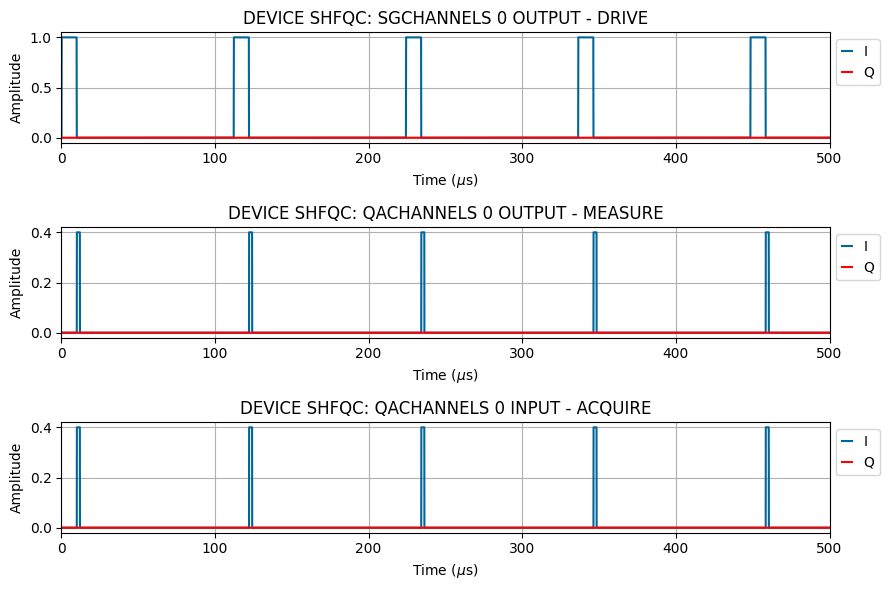

In [97]:
compiled_qspec = session.compile(exp_qspec)
plot_simulation(compiled_qspec, 0, 500e-6)